In [7]:
import numpy as np
from scipy.interpolate import interp1d
import qnm_filter
import sys
import qnm
import random
import argparse
import scipy.linalg as sl
from scipy.special import logsumexp
from pathlib import Path
import glob
import matplotlib.pyplot as pl

In [10]:
delta_mass = 1 #0.1
delta_chi = 0.01 #0.005
massspace = np.arange(10, 110, delta_mass)
chispace = np.arange(0., 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

t0 = 0

In [18]:
def signal_creator():
    global signal, signal220, signal330, signal440, time_arr, signalH_noise, signalL_noise
    injected = (random.uniform(40, 80), 0.7)
    mass = qnm_filter.Filter.mass_unit(injected[0])
    omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=injected[1])[0]
    omega330 = qnm.modes_cache(s=-2,l=3,m=3,n=0)(a=injected[1])[0]
    omega440 = qnm.modes_cache(s=-2,l=4,m=4,n=0)(a=injected[1])[0]

    mmax = 0.8 * 1e-21 
    phase220 = random.uniform(0, 2*np.pi)
    A220x = mmax*np.cos(phase220)
    A220y = mmax*np.sin(phase220)
#     phase330 = 0
#     A330x = mmax*np.cos(phase330)
#     A330y = mmax*np.sin(phase330)
#     phase440 = 0
#     A440x = mmax*np.cos(phase440)
#     A440y = mmax*np.sin(phase440)

    amp220 = 1.2
#     amp330 = 1.2
#     amp440 = 0.7

    sampling_frequency = 4096 * 1  # in Hz
    duration = 2  # in second
    time_arr = np.arange(-duration / 2, duration / 2, 1 / sampling_frequency)
    signal220 = np.real(amp220 * (A220x + 1j * A220y) * np.exp(-1j * omega220 * np.abs(time_arr / mass)))
#     signal330 = np.real(amp330 * (A330x + 1j * A330y) * np.exp(-1j * omega330 * np.abs(time_arr / mass)))
#     signal440 = np.real(amp440 * (A440x + 1j * A440y) * np.exp(-1j * omega440 * np.abs(time_arr / mass)))

    #CN section
    ifo_H1 = qnm_filter.set_bilby_predefined_ifo(
    "H1", sampling_frequency, duration, start_time=-duration / 2
    )
    signalH_noise = qnm_filter.bilby_get_strain(ifo_H1, 0.0)
    ifo_L1 = qnm_filter.set_bilby_predefined_ifo(
    "L1", sampling_frequency, duration, start_time=-duration / 2
    )
    signalL_noise = qnm_filter.bilby_get_strain(ifo_L1, 0.0)

In [13]:
def analysis():
    fit = qnm_filter.Network(**input)
    fit.original_data = {}
    fit.original_data['H1'] = qnm_filter.RealData(NR_signal, index=time_arr)
    fit.original_data['L1'] = qnm_filter.RealData(NR_signal, index=time_arr)
    fit.detector_alignment()
    fit.condition_data('original_data', **input)

    fit.pure_noise = {}
    fit.pure_noise["H1"] = qnm_filter.RealData(signalH_noise, index=time_arr)
    fit.pure_noise["L1"] = qnm_filter.RealData(signalL_noise, index=time_arr)
    fit.condition_data('pure_noise', **input)
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()

    fit.pure_nr = {}
    fit.pure_nr['H1'] = qnm_filter.RealData(NR_signal, index=time_arr)
    fit.pure_nr['L1'] = qnm_filter.RealData(NR_signal, index=time_arr)
    fit.condition_data('pure_nr')
    SNR = fit.compute_SNR(fit.truncate_data(fit.original_data)['H1'], fit.truncate_data(fit.pure_nr)['H1'], 'H1', False)

    likelihood_data, evidence = qnm_filter.parallel_compute(
        fit, massspace, chispace, num_cpu=8, **input)
    credible_region = qnm_filter.find_credible_region(likelihood_data)

#     # Plotting
#     pl.rc('figure', figsize=(6.1, 6.6))
#     fig, ax = pl.subplots()
#     contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
#                            origin='lower', alpha=0.6, linestyles='--')
#     dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors='red',
#                         linestyles='--')
#     ax.scatter(x=injected[0], y=injected[1], s=255, marker='+',
#                c='g', linewidths=4, label='IMR')
#     ax.plot(np.NaN, np.NaN, '-', color='none',
#             label='ln(Evidence) = %.1F' % evidence)

#     cbar = fig.colorbar(contours, orientation="horizontal",
#                         pad=0.15, format='%3.2f')
#     cbar.set_label(r'$\ln$ likelihood', fontsize=15)
#     cbar.set_ticks(np.linspace(np.min(likelihood_data),
#                    np.max(likelihood_data), 5))

#     ax.set_title('220+330+440 waveform \n $t_{init}$ + ' + str((input['t_init']-t0)/mass) +
#                  r'$M$, filters = ' + filter_str)
#     pl.legend(loc='lower right')
#     pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
#     pl.ylabel(r'$\chi_f$', fontsize=13)
    return evidence

## Overlap between 220 and 210

0.23265983842924642
0.2262232751959029
0.2308319321533887
0.22445610497704693
0.22764500382130093
0.23032269983410703
0.20673247179622656
0.23511229917436016
0.22087360121740784
0.23013379431842917


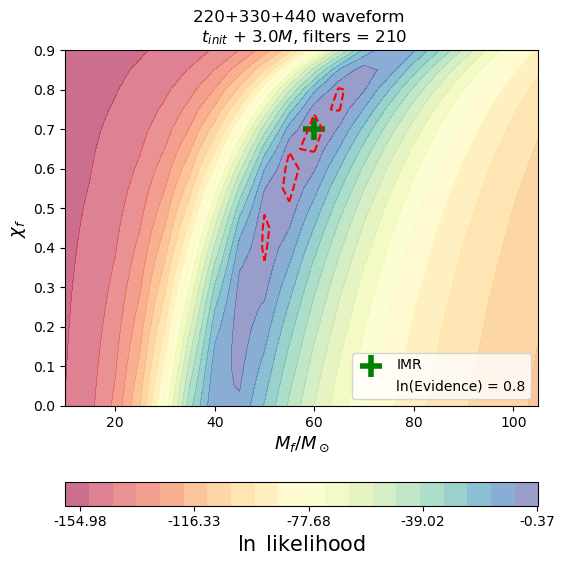

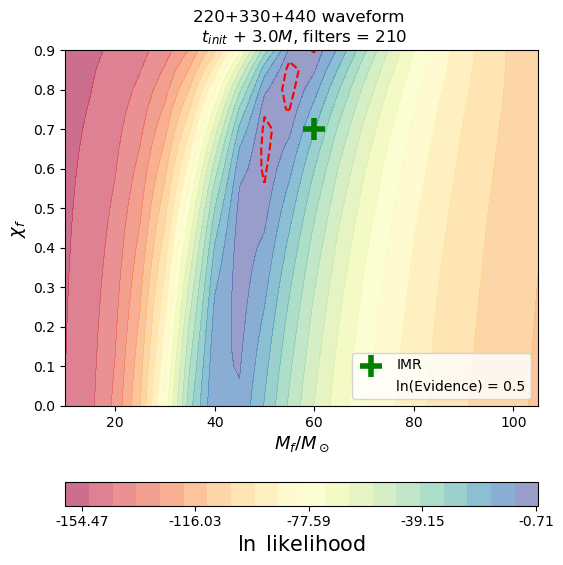

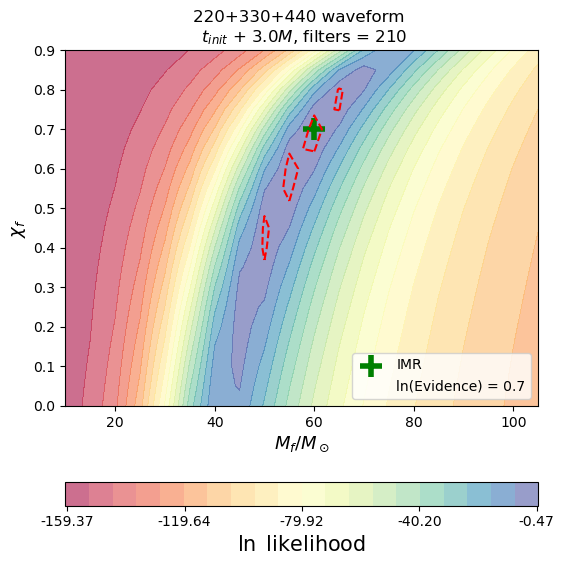

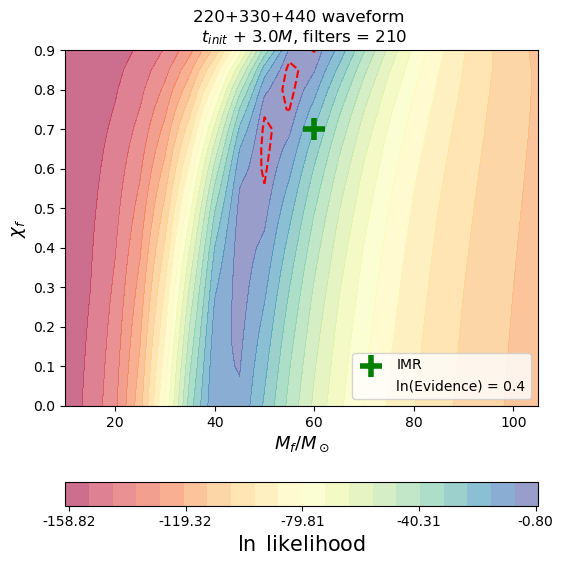

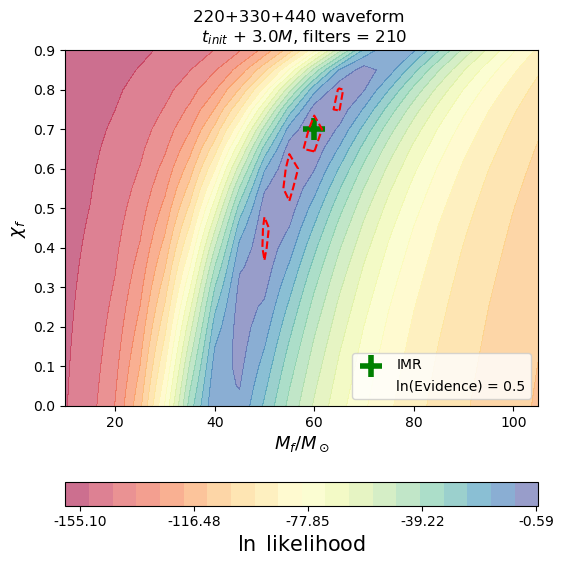

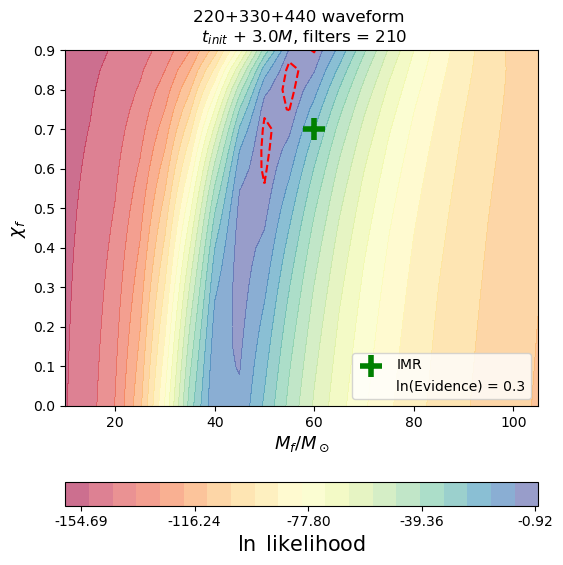

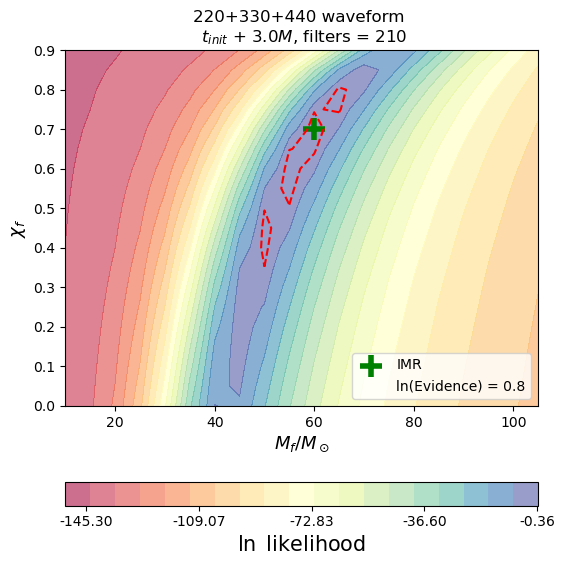

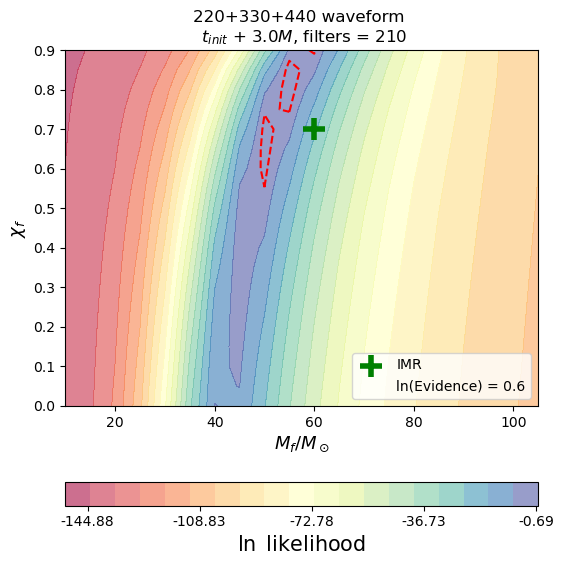

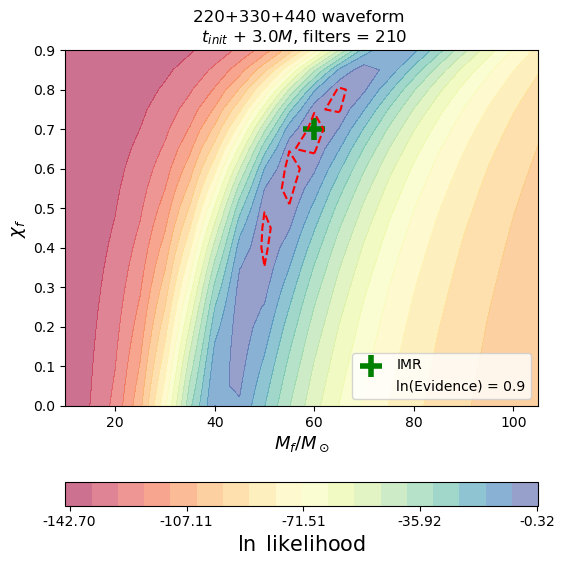

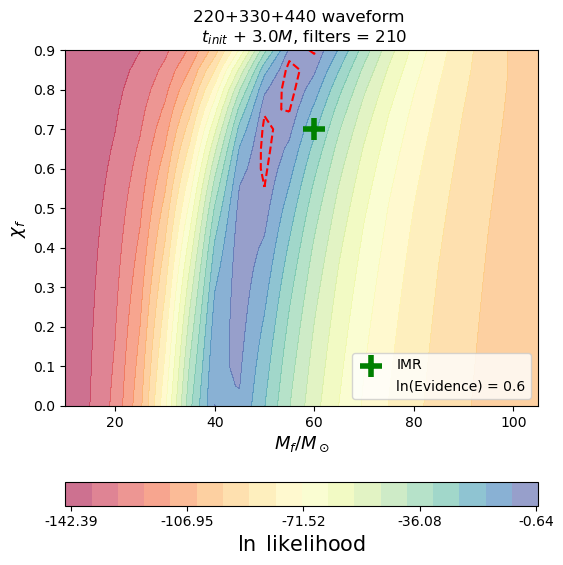

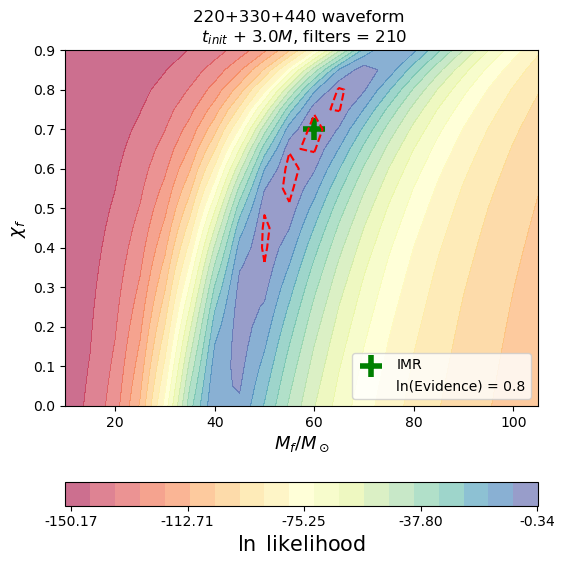

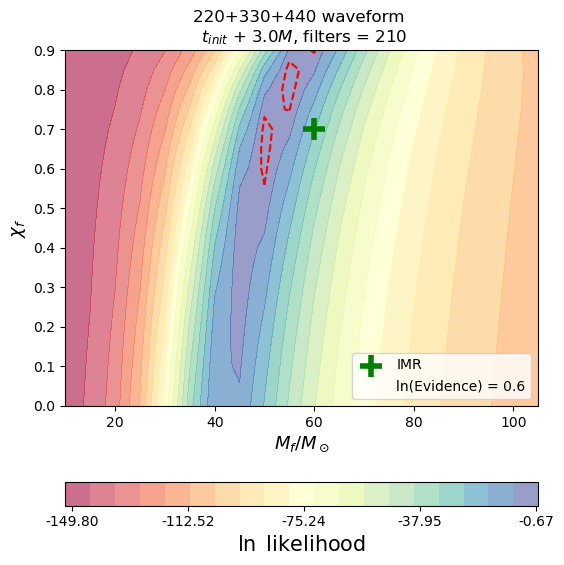

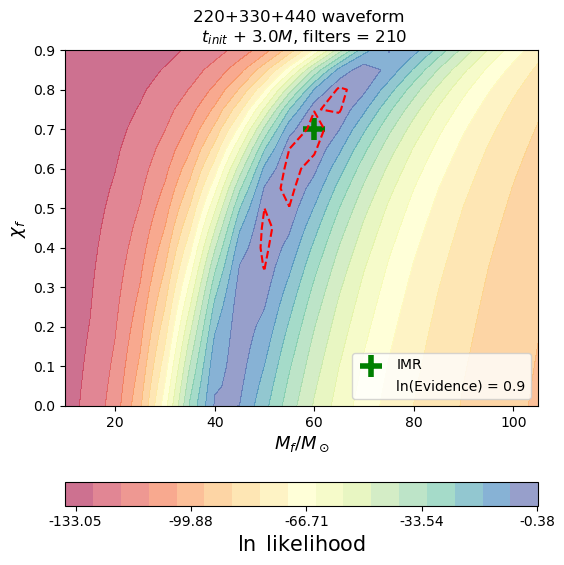

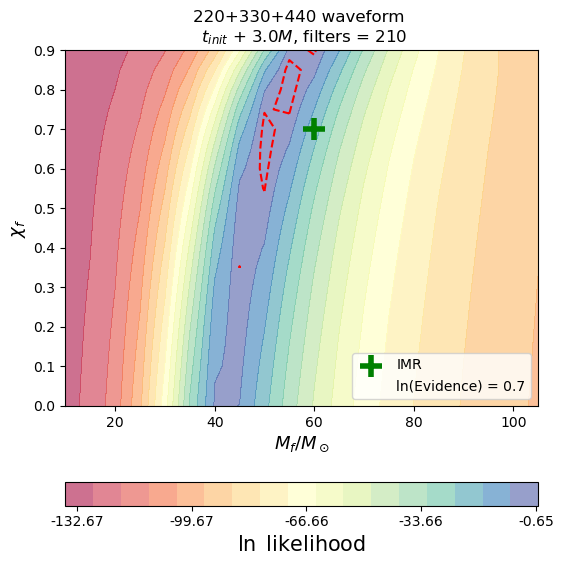

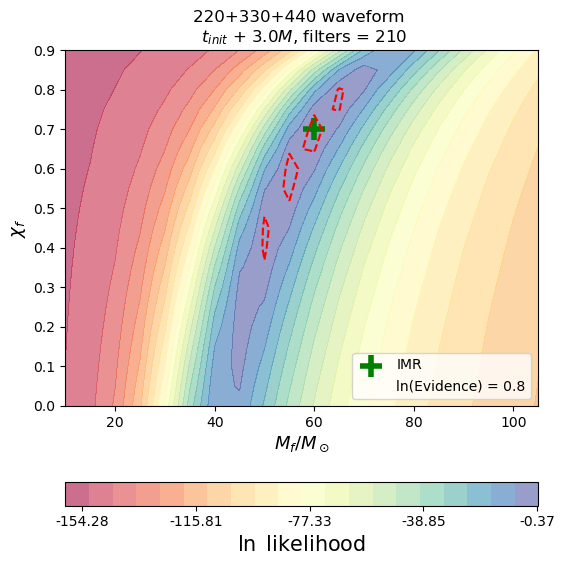

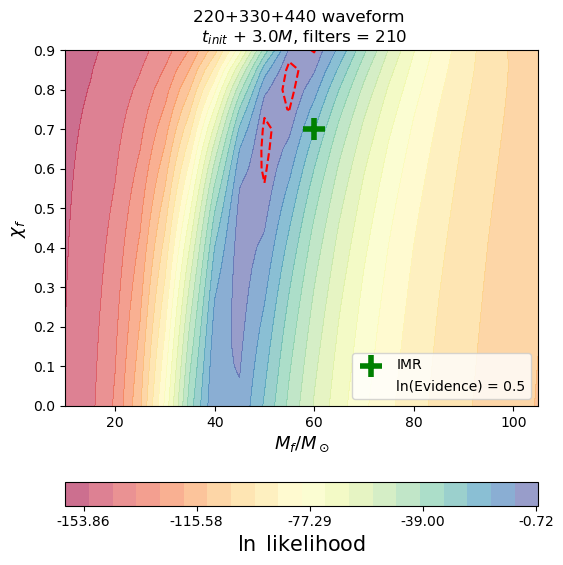

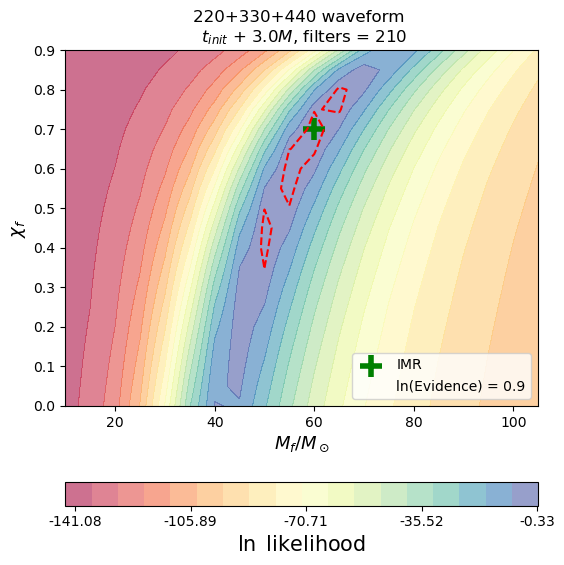

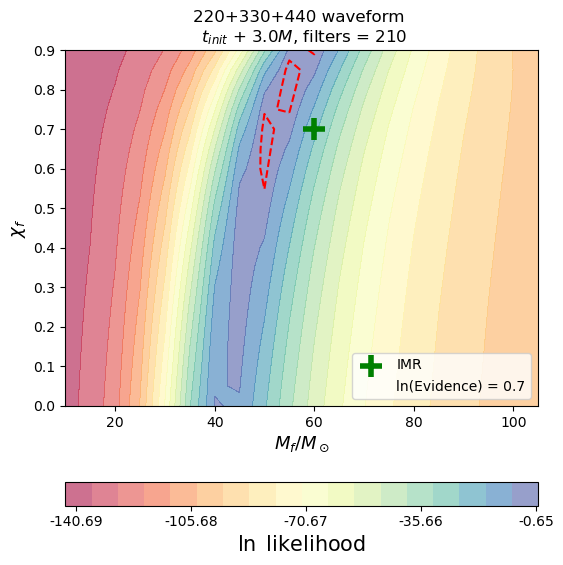

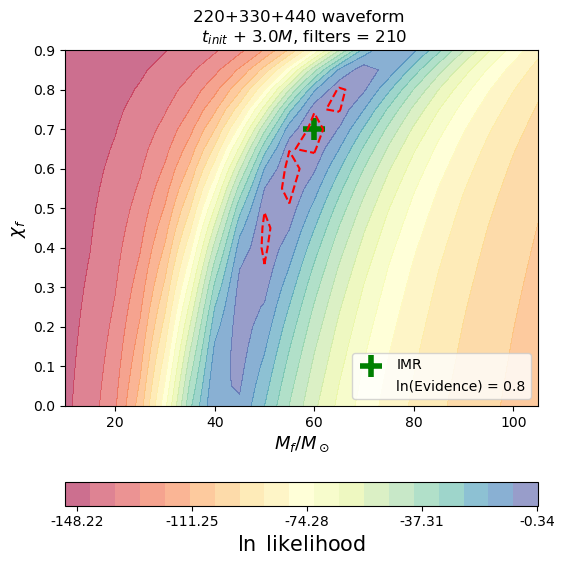

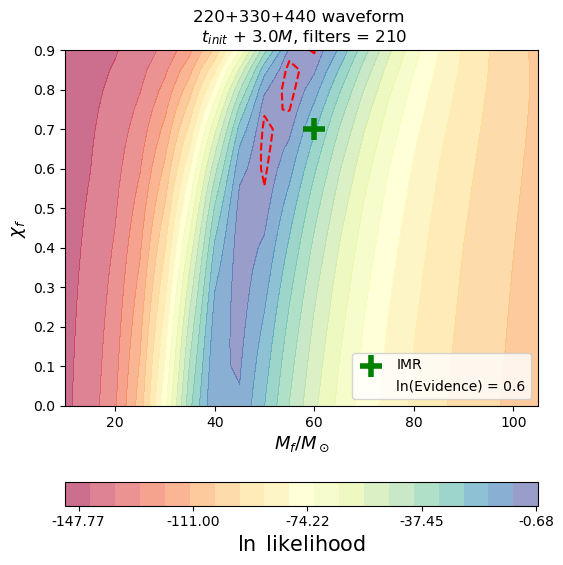

In [19]:
input = dict(t_init=3*mass,
             segment_length=0.2,
             srate=4096,
             ra=None, dec=None,
             flow=20)
for _ in range(10):
    signal_creator()
    input['model_list']=[(2,2,0,'p')]
    evidence220 = analysis()
    input['model_list']=[(2,1,0,'p')]
    evidence210 = analysis()
    print(evidence220 - evidence210)

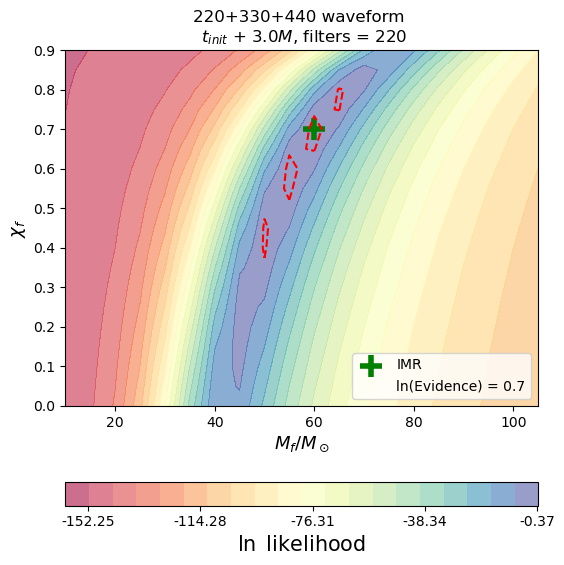

In [14]:
input = dict(model_list=[(2,2,0,'p')],
             t_init=3*mass,
             segment_length=0.2,
             srate=4096,
             ra=None, dec=None,
             flow=20)
filter_str = '+'.join(f"{item[0]}{item[1]}{item[2]}" for item in input['model_list'])
NR_signal = signal220

evidence = analysis()

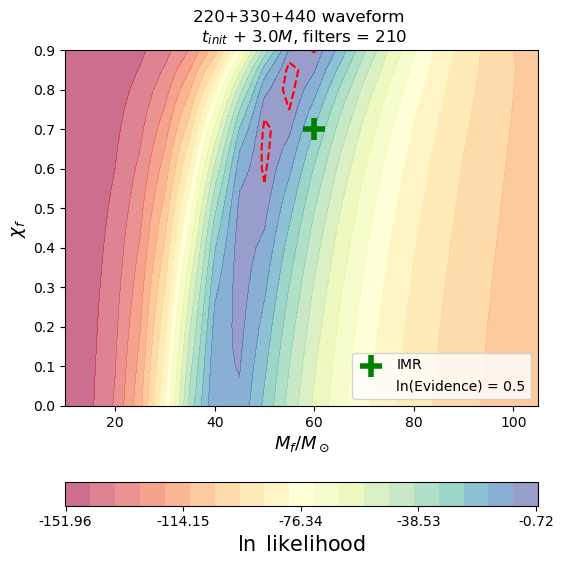

In [15]:
input = dict(model_list=[(2,1,0,'p')],
             t_init=3*mass,
             segment_length=0.2,
             srate=4096,
             ra=None, dec=None,
             flow=20)
filter_str = '+'.join(f"{item[0]}{item[1]}{item[2]}" for item in input['model_list'])
NR_signal = signal220

evidence = analysis()